<a href="https://colab.research.google.com/github/jafetimbre/ms-school-stuff/blob/master/image-processing/coin_counter/final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip uninstall -y -q opencv-python opencv-contrib-python
!pip install -q opencv-contrib-python==3.4.2.17

     |████████████████████████████████| 30.6 MB 27 kB/s 


In [156]:
import cv2
import numpy as np
from urllib.request import urlopen
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
from matplotlib import cm    
import random

In [23]:
coin_file_names = [
    "5bani",
    "10bani",
    "50bani",
]

base_coins = {}
for name in coin_file_names:
    url = f"https://raw.githubusercontent.com/jafetimbre/ms-school-stuff/master/image-processing/coin_counter/res/manual/{name}.jpg"
    req = urlopen(url)
    arr = np.asarray(bytearray(req.read()), dtype=np.uint8)
    base_coins[name] = cv2.imdecode(arr, -1)

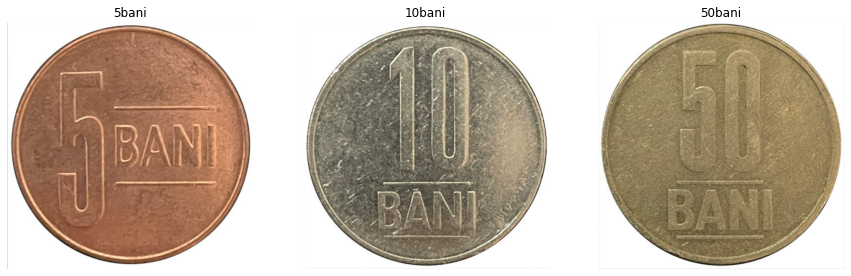

In [24]:
fig, axs = plt.subplots(1, 3, figsize=(15,8))

for i, coin in enumerate(base_coins.items()):
    c_name, c_img = coin
    axs[i].axis("off")
    axs[i].set_title(c_name)
    axs[i].imshow(cv2.cvtColor(c_img, cv2.COLOR_BGR2RGB))

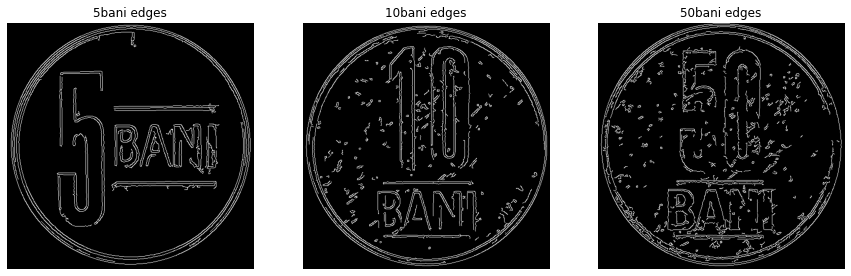

In [111]:
fig, axs = plt.subplots(1, 3, figsize=(15,8))

for i, coin in enumerate(base_coins.items()):
    c_name, c_img = coin

    gray = cv2.cvtColor(c_img, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (5, 5), 0)

    if c_name == "5bani":
        cny = cv2.Canny(blur, 30, 150)
    elif c_name == "10bani":
        cny = cv2.Canny(blur, 100, 200)
    elif c_name == "50bani":
        cny = cv2.Canny(blur, 50, 100)
    else:
        cny = cv2.Canny(blur, 30, 150)

    axs[i].axis("off")
    axs[i].set_title(f"{c_name} edges")
    axs[i].imshow(cny, cmap=cm.gray, vmin=0, vmax=255)

In [ ]:
nr_features = 5000

sift = cv2.xfeatures2d.SIFT_create(nr_features)
bf = cv2.BFMatcher()

In [25]:
base_refs = {}

for name, coin in base_coins.items():
    gray = cv2.cvtColor(coin, cv2.COLOR_BGR2GRAY)
    base_refs[name] = sift.detectAndCompute(coin, None)

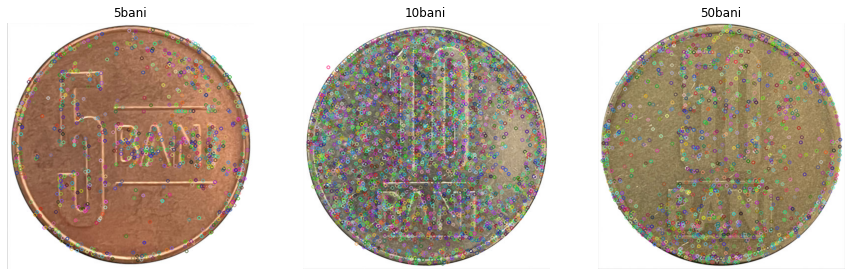

In [99]:
fig, axs = plt.subplots(1, 3, figsize=(15,8))

for i, data in enumerate(base_refs.items()):
    name, (keypoints, descriptors) = data

    axs[i].axis("off")
    axs[i].set_title(name)
    key_img = cv2.drawKeypoints(base_coins[name], keypoints[:], None)
    axs[i].imshow(cv2.cvtColor(key_img, cv2.COLOR_BGR2RGB))

In [27]:
req = urlopen("https://raw.githubusercontent.com/jafetimbre/ms-school-stuff/master/image-processing/coin_counter/res/manual/conis.jpg")
arr = np.asarray(bytearray(req.read()), dtype=np.uint8)
coins = cv2.imdecode(arr, -1)

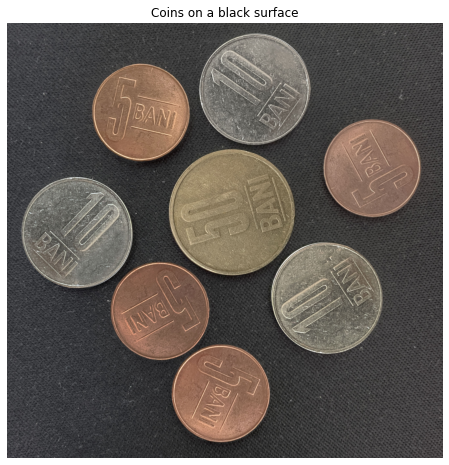

In [144]:
plt.figure(figsize = (8, 8))
plt.axis("off")
plt.title("Coins on a black surface")
plt.imshow(cv2.cvtColor(coins, cv2.COLOR_BGR2RGB))

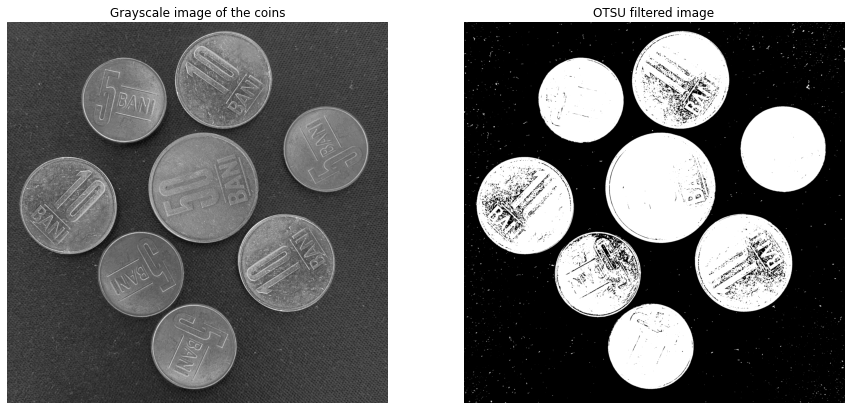

In [110]:
det_coins = coins.copy()
gray = cv2.cvtColor(det_coins, cv2.COLOR_BGR2GRAY)
thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

fig, axs = plt.subplots(1, 2, figsize=(15,8))
for i, im in enumerate([gray, thresh]):
    axs[i].axis("off")
    axs[i].set_title("Grayscale image of the coins" if i == 0 else "OTSU filtered image")
    axs[i].imshow(im, cmap=cm.gray, vmin=0, vmax=255)

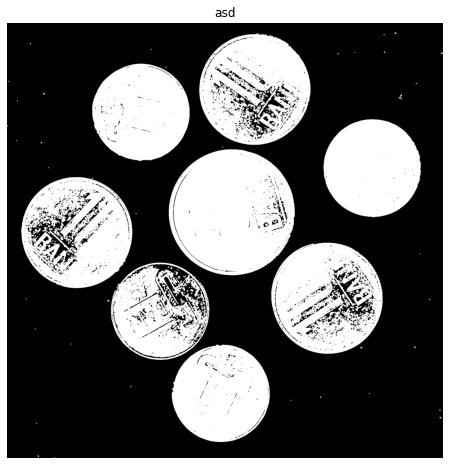

In [121]:
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=1)

plt.figure(figsize = (8, 8))
plt.axis("off")
plt.title("asd")
plt.imshow(opening, cmap=cm.gray, vmin=0, vmax=255)

In [125]:
_, contour, hierarchy = cv2.findContours(opening, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

In [126]:
coins_contours = []

for cnt in contour:
    area = cv2.contourArea(cnt)
    if area > 100:
        approx_poly = cv2.approxPolyDP(cnt, .03 * cv2.arcLength(cnt, True), True)
        is_convex = cv2.isContourConvex(approx_poly)
        if is_convex:
            coins_contours.append(cnt)

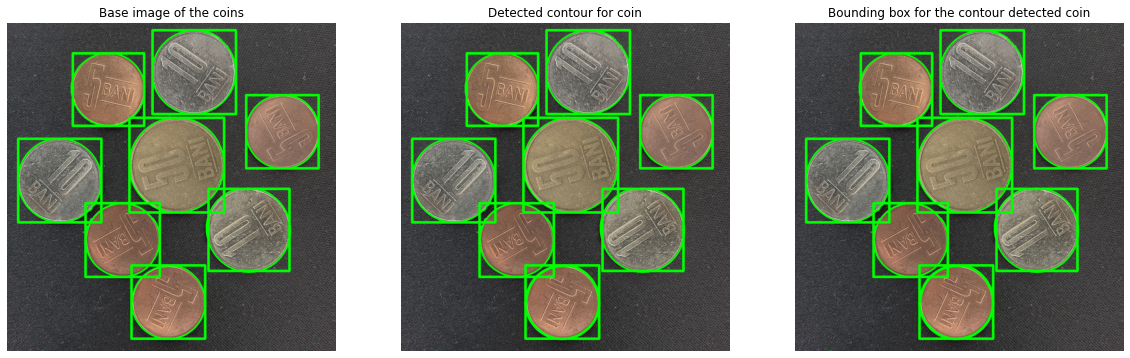

In [148]:
im_c = det_coins.copy()
cnt = coins_contours[0]

cv2.drawContours(image=im_c, contours=[cnt], contourIdx=-1, color=(0, 255, 0), thickness=20, lineType=cv2.LINE_AA)
im_r = im_c.copy()
approx_poly = cv2.approxPolyDP(cnt, .03 * cv2.arcLength(cnt, True), True)
x, y, w, h = cv2.boundingRect(approx_poly)
cv2.rectangle(im_r, (x, y), (x+w, y+h), (0, 255, 0), 20)

fig, axs = plt.subplots(1, 3, figsize=(20,8))
titles = [ "Base image of the coins", "Detected contour for coin", "Bounding box for the contour detected coin"]
for i, im in enumerate([det_coins, im_c, im_r]):
    axs[i].axis("off")
    axs[i].set_title(titles[i])
    axs[i].imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))

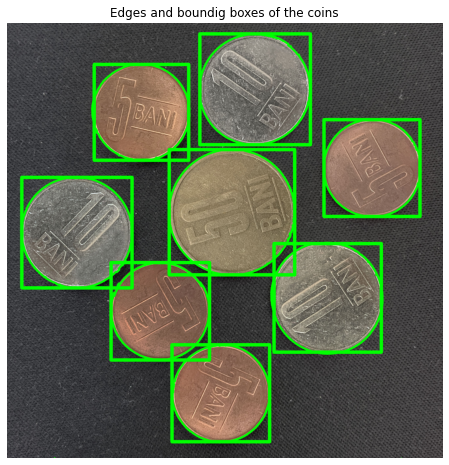

In [146]:
coins_roi = []

for cnt in coins_contours:
    cv2.drawContours(image=det_coins, contours=[cnt], contourIdx=-1, color=(0, 255, 0), thickness=10, lineType=cv2.LINE_AA)
    approx_poly = cv2.approxPolyDP(cnt, .03 * cv2.arcLength(cnt, True), True)
    x, y, w, h = cv2.boundingRect(approx_poly)
    cv2.rectangle(det_coins, (x, y), (x+w, y+h), (0, 255, 0), 10)
    coins_roi.append((x, y, w, h))

plt.figure(figsize = (8, 8))
plt.axis("off")
plt.title("Edges and boundig boxes of the coins")
plt.imshow(cv2.cvtColor(det_coins, cv2.COLOR_BGR2RGB))

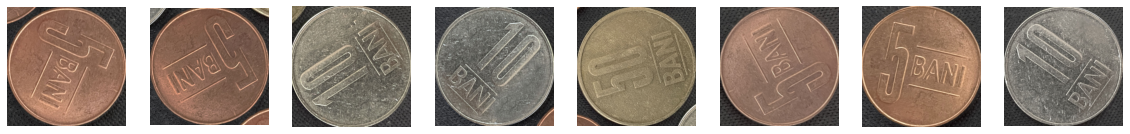

In [147]:
nr_coins = len(coins_roi)
fig, axs = plt.subplots(1, nr_coins, figsize=(20,10))

for i, roi in enumerate(coins_roi):
    axs[i].axis("off")
    coin = coins[roi[1]:roi[1]+roi[3], roi[0]:roi[0]+roi[2]]
    axs[i].imshow(cv2.cvtColor(coin, cv2.COLOR_BGR2RGB))

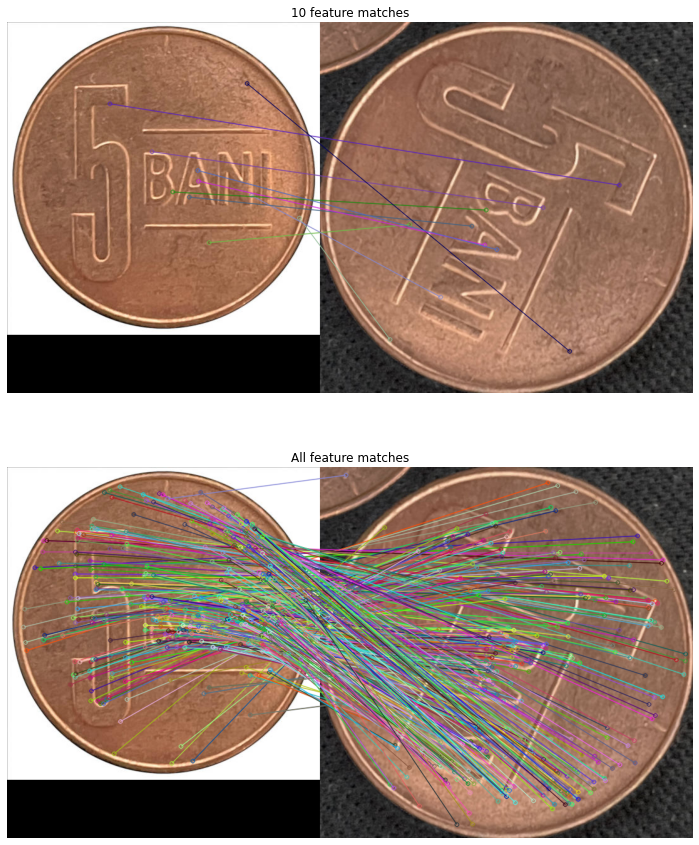

In [185]:
k1, d1 = base_refs["5bani"]

roi = coins_roi[0]
coin = coins[roi[1]:roi[1]+roi[3], roi[0]:roi[0]+roi[2]]

gray = cv2.cvtColor(coin, cv2.COLOR_BGR2GRAY)

k2, d2 = sift.detectAndCompute(gray, None)

matches = bf.knnMatch(d1, d2, k=2)

good_matches = []
for m1, m2 in matches:
    if m1.distance < 0.6 * m2.distance:
        good_matches.append([m1])

matches_to_show = 10

SIFT_matches_all = cv2.drawMatchesKnn(base_coins["5bani"], k1, coin, k2, good_matches, None, flags=2)
np.random.shuffle(good_matches)
SIFT_matches_some = cv2.drawMatchesKnn(base_coins["5bani"], k1, coin, k2, good_matches[:matches_to_show], None, flags=2)

fig, axs = plt.subplots(2, 1, figsize=(18, 15))
titles = [f"{matches_to_show} feature matches", "All feature matches"]
for i, im in enumerate([SIFT_matches_some, SIFT_matches_all]):
    axs[i].axis("off")
    axs[i].set_title(titles[i])
    axs[i].imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))

In [49]:
# TODO: break down the detection proccess like below
# g1 = cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY)
# g2 = cv2.cvtColor(im2, cv2.COLOR_BGR2GRAY)


# k1, d1 = sift.detectAndCompute(g1, None)
# k2, d2 = sift.detectAndCompute(g2, None)

# matches = bf.knnMatch(d1, d2, k=2)

# good_matches = []
# for m1, m2 in matches:
#   if m1.distance < 0.2*m2.distance:
#     good_matches.append([m1])

# SIFT_matches = cv2.drawMatchesKnn(im1, k1, im2, k2, good_matches, None, flags=2)

# show_figure(SIFT_matches)

In [59]:
results = []
for roi in coins_detected:
    coin = coins[roi[1]:roi[1]+roi[3], roi[0]:roi[0]+roi[2]]
    gray = cv2.cvtColor(coin, cv2.COLOR_BGR2GRAY)
    k2, d2 = sift.detectAndCompute(gray, None)
    res = {}
    for data in base_refs.items():
        name, (k1, d1) = data
        matches = bf.knnMatch(d1, d2, k=2)
        good_matches = []
        for m1, m2 in matches:
            if m1.distance < 0.3 * m2.distance:
                good_matches.append([m1])
        res[name] = len(good_matches)
    results.append(max(res, key=res.get))

In [60]:
results

['5bani', '5bani', '10bani', '10bani', '50bani', '5bani', '5bani', '10bani']



---




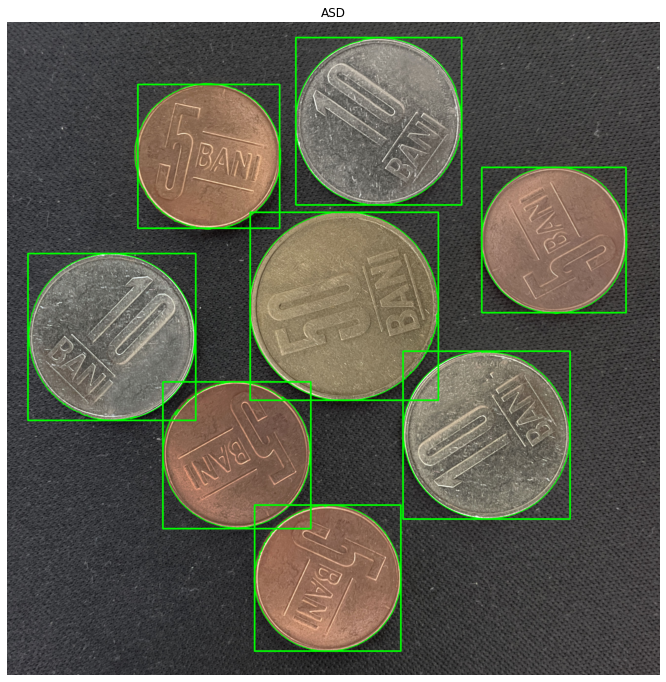

In [42]:
img = coins.copy()
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=1)

_, contour, hierarchy = cv2.findContours(opening, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

coins_detected = []

for cnt in contour:
    area = cv2.contourArea(cnt)
    if area > 100:
        approx_poly = cv2.approxPolyDP(cnt, .03 * cv2.arcLength(cnt, True), True)
        is_convex = cv2.isContourConvex(approx_poly)

        if is_convex:
            cv2.drawContours(image=img, contours=[cnt], contourIdx=-1, color=(0, 255, 0), thickness=2, lineType=cv2.LINE_AA)
            x, y, w, h = cv2.boundingRect(approx_poly)
            cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 5)
            coins_detected.append((x, y, w, h))

plt.figure(figsize = (12,12))
plt.axis("off")
plt.title("ASD")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [ ]:
def detect_coin(img, k=2):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    keypoints, descriptors = orb.detectAndCompute(gray, None)
    res = {}
    for data in refs.items():
        name, (key, desc) = data
        matches = bf.knnMatch(desc, descriptors, k=2)
        good_matches = []
        for m, n in matches:
            if m.distance < 0.75 * n.distance:
                good_matches.append([m])
        res[name] = len(good_matches)
    return res

In [ ]:


g1 = cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY)
g2 = cv2.cvtColor(im2, cv2.COLOR_BGR2GRAY)

if WCANNY:
    b1 = cv2.GaussianBlur(g1, (5, 5), 0)
    b2 = cv2.GaussianBlur(g2, (5, 5), 0)

    g1 = cv2.Canny(b1, 30, 150)
    g2 = cv2.Canny(b2, 30, 150)


k1, d1 = sift.detectAndCompute(g1, None)
k2, d2 = sift.detectAndCompute(g2, None)

matches = bf.knnMatch(d1, d2, k=2)

good_matches = []
for m1, m2 in matches:
  if m1.distance < 0.2*m2.distance:
    good_matches.append([m1])

SIFT_matches = cv2.drawMatchesKnn(im1, k1, im2, k2, good_matches, None, flags=2)

show_figure(SIFT_matches)